# Final Fine-Tuning and Evaluation on the Full Dataset

This notebook loads the pretrained ViT model, fine-tunes it on the entire blood cell dataset, and evaluates its performance.


## 1. Setup and Device Selection

Import required libraries and check for GPU availability.


In [1]:
# Import torch and torchvision, and check for GPU
import torch
import torchvision

from going_modular.GPU_check import GPU_check

device = GPU_check()  # Will use CUDA if available

CUDA available: True
CUDA devices: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


## 2. Load Pretrained ViT Model

Load the Vision Transformer model and its required image transforms.


In [2]:
# Load the ViT model and its transforms
from going_modular.vit_model import create_ViT
vit, vit_transforms = create_ViT()

## 3. Load Saved Model Weights

Restore the trained model weights from the previous training session.


In [3]:
# Load the saved model weights
import torch

vit.load_state_dict(torch.load("models/My_ViT_16b.pth"))

<All keys matched successfully>

In [4]:
vit.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## 4. Prepare DataLoaders

Set up dataloaders for 20% 0f the dataset using the correct transforms.


In [5]:
# Prepare dataloaders for training and testing
from pathlib import Path
from going_modular import data_setup

DATA_DIR = Path("Blood cells datasets/")

# Create dataloaders with the required transforms
train_dataloader, test_dataloader, train_dataset, test_dataset, class_names = data_setup.create_dataloaders(
    root=DATA_DIR,
    transform=vit_transforms,
    batch_size=32
)

# Optionally, use 20% of the data for faster experimentation
train_dataloader_20_percent = data_setup.get_x_percent_dataloader(
    dataset=train_dataset,
    percent=0.2,
    shuffle=True
)

test_dataloader_20_percent = data_setup.get_x_percent_dataloader(
    dataset=test_dataset,
    percent=0.2,
    shuffle=False
)

## 5. Fine-Tune the Model

Train the model on the training set and evaluate on the test set.


In [6]:
# Fine-tune the model
from going_modular.engine import train

# Set up optimizer and loss function
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
vit_results = train(
    model=vit,
    train_dataloader=train_dataloader_20_percent,
    test_dataloader=test_dataloader_20_percent,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    epochs = 7
)

  0%|          | 0/7 [00:00<?, ?it/s]

Looked at 0/11617 samples
Looked at 1152/11617 samples
Looked at 2304/11617 samples
Looked at 3456/11617 samples
Looked at 4608/11617 samples
Looked at 5760/11617 samples
Looked at 6912/11617 samples
Looked at 8064/11617 samples
Looked at 9216/11617 samples
Looked at 10368/11617 samples
Looked at 11520/11617 samples


Train loss: 0.67927 | Train accuracy: 77.88%
Test loss: 0.61584 | Test accuracy: 78.39%


Looked at 0/11617 samples
Looked at 1152/11617 samples
Looked at 2304/11617 samples
Looked at 3456/11617 samples
Looked at 4608/11617 samples
Looked at 5760/11617 samples
Looked at 6912/11617 samples
Looked at 8064/11617 samples
Looked at 9216/11617 samples
Looked at 10368/11617 samples
Looked at 11520/11617 samples


Train loss: 0.55589 | Train accuracy: 81.70%
Test loss: 0.55673 | Test accuracy: 79.59%


Looked at 0/11617 samples
Looked at 1152/11617 samples
Looked at 2304/11617 samples
Looked at 3456/11617 samples
Looked at 4608/11617 samples
Looked at 5760/11617 samples
Looked at

## 6. Plot Training and Validation Loss Curves


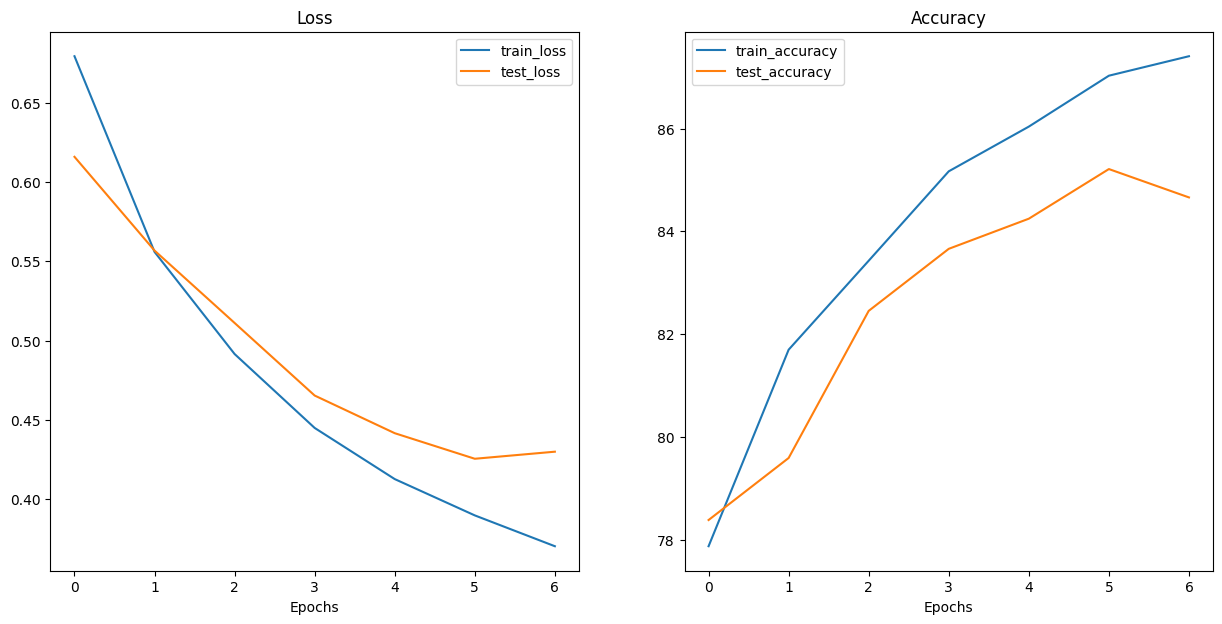

In [7]:
# Plot loss and accuracy curves
from going_modular.helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

## 7. Evaluate Model with Confusion Matrix

Visualize the model's performance across all classes.


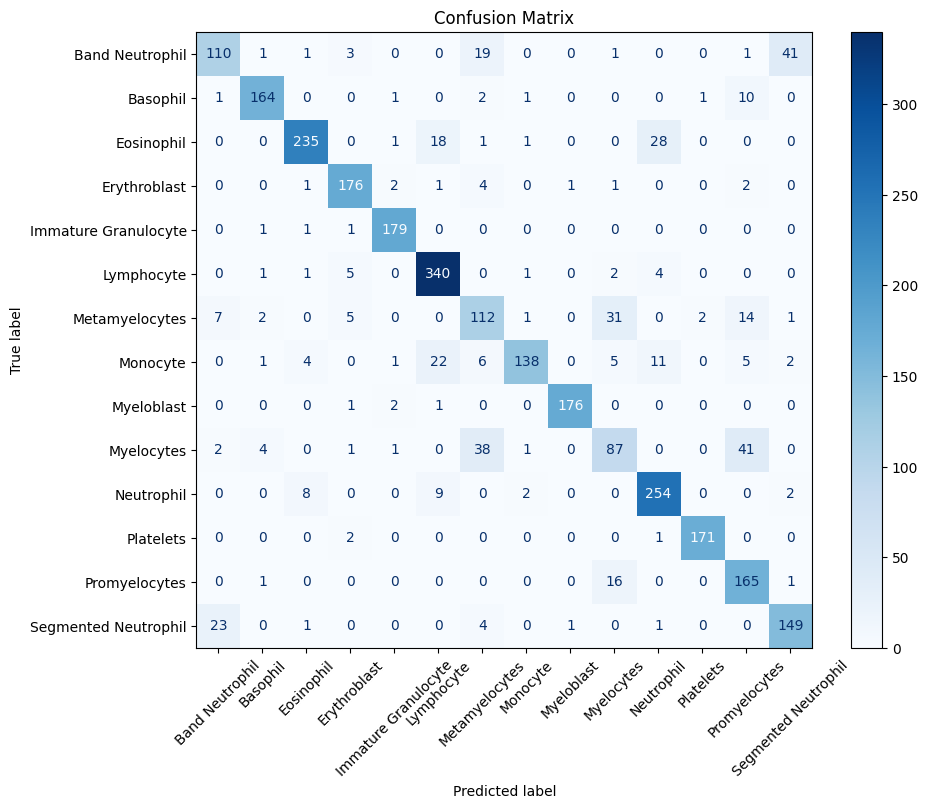

In [8]:
# Plot confusion matrix for test set predictions
from going_modular import utils
utils.confusion_matrix_and_plot(
    model=vit,
    dataloader=test_dataloader_20_percent,
    class_names=class_names,
    device=device
)

## 8. Save the model

In [9]:
from going_modular import utils

utils.save_model(vit, "models/", "My_ViT_16b.pth")

[INFO] ✅ Model saved to: models\My_ViT_16b.pth
